# Translation

## Diretory and library

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator
import spacy

import math
import time
import numpy as np
import os
import random

In [2]:
# 專案的根目錄路徑
ROOT_DIR = os.getcwd()

# 置放訓練資料的目錄
DATA_PATH = os.path.join(ROOT_DIR, "data")

# 訓練資料檔
DATA_FILE = os.path.join(DATA_PATH, "cmn-tw.txt")

## Data loading

In [3]:
input_texts = []
target_texts = []


input_characters = set() # 英文字符集
target_characters = set() # 中文字符集



#open txt file
lines = open(DATA_FILE, mode="r", encoding="utf-8").read().split('\n')
np.random.shuffle(lines) 
print(type(lines),len(lines))

<class 'list'> 19577


### Tokenizer 

In [4]:
spacy_en = spacy.load('en_core_web_sm')

def tokenize_en(text):
   #将英语进行分词，颠倒顺序
    return [tok.text for tok in spacy_en.tokenizer(text)][::-1]

def tokenize_cn(texts):
    token = []
    for text in texts:
        for char in text:
            if char not in token:
                token.append(char)
    return token

# tokenize_cn(train_data.examples[1].trg)

## Corpus construction

In [5]:
for line in lines[: len(lines)]:
    input_text, target_text = line.split('\t')
    
    # 我們使用“tab”作為“開始序列[SOS]”字符或目標，“\n”作為“結束序列[EOS]”字符。 <-- **重要
#     target_text = '\t' + target_text + '\n'
    
    input_texts.append(input_text)
    target_texts.append(target_text)
    
    for char in tokenize_en(input_text):       # English words corpus
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:      # Chinese words corpus
        if char not in target_characters:
            target_characters.add(char)     
            
            
input_characters = sorted(list(input_characters)) # 全部輸入的字符集
target_characters = sorted(list(target_characters)) # 全部目標字符集

num_encoder_tokens = len(input_characters) # 所有輸入字符的數量
num_decoder_tokens = len(target_characters) # 所有輸目標字符的數量

max_encoder_seq_length = max([len(txt) for txt in input_texts]) # 最長的輸入句子長度
max_decoder_seq_length = max([len(txt) for txt in target_texts]) # 最長的目標句子長度

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)



Number of samples: 19577
Number of unique input tokens: 6766
Number of unique output tokens: 2720
Max sequence length for inputs: 165
Max sequence length for outputs: 44


### Create My own Translationdatasets

In [6]:
def Write_Text(file_name,contant):
    # file_name = 'test.txt'
    with open(file_name,"a+") as f:
        f.writelines(contant)
        f.writelines("\n")

import os

file_write_obj = open("./data/src_en.txt", 'w',encoding="utf-8")
# print(type(file_write_obj))
for var in input_texts:
#     print(var)
    file_write_obj.writelines(var)
    file_write_obj.write('\n')
file_write_obj.close()

file_write_obj = open("./data/trg_cn.txt", 'w',encoding="utf-8")
# print(type(file_write_obj))
for var in target_texts:
#     print(var)
    file_write_obj.writelines(var)
    file_write_obj.write('\n')
file_write_obj.close()

names = ['train_src_en.txt','val_src_en.txt','test_src_en.txt','train_trg_cn.txt','val_trg_cn.txt','test_trg_cn.txt']

def create_train_val_test_txt(names):
    

    for i,name in enumerate(names):
        file = open('./data/'+ name, 'w',encoding="utf-8")
        if i<3:
            data = input_texts.copy()
        else:
            data = target_texts.copy()

        if name.split('_')[0] == 'train':
            data = data[:18000]
        elif name.split('_')[0] == 'val':
            data = data[18000:19000]
        else: data = data[19000:]

        for var in data:
    #     print(var)
            file.writelines(var)
            file.write('\n')
        file.close()
        
create_train_val_test_txt(names)        

## Token text 

In [7]:
SRC = Field(sequential=True,
            use_vocab=True,
            tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(sequential=True, 
            use_vocab=True, 
            tokenize = tokenize_cn,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

## TranslationDataset instanciate

In [8]:
T_data = TranslationDataset(path = './data/' , exts = ('src_en.txt','trg_cn.txt'), fields = (SRC,TRG))
train_data, valid_data, test_data = T_data.splits(path = './data/' , exts = ('_src_en.txt','_trg_cn.txt'),fields = (SRC,TRG))

In [9]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")
print(type(train_data))

Number of training examples: 18000
Number of validation examples: 1000
Number of testing examples: 577
<class 'torchtext.datasets.translation.TranslationDataset'>


In [10]:
print(vars(train_data.examples[1]))
# print(vars(SRC),'\n\n',vars(TRG))

{'src': ['?', 'electricity', 'or', 'gas', 'by', 'cook', 'you', 'do'], 'trg': ['你', '煮', '飯', '用', '瓦', '斯', '還', '是', '電', '？']}


## One-hot encoding

In [11]:
# 设置最小词频为2，当一个单词在数据集中出现次数小于2时会被转换为<unk>字符。
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

print(f"Unique tokens in source (de) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(SRC.vocabTRG.vocab)}")

Unique tokens in source (de) vocabulary: 3507
Unique tokens in target (en) vocabulary: 2188


<img src="https://camo.githubusercontent.com/44a4c60ee9446a14effc6057a16c9f12b61102b5/68747470733a2f2f692e696d6775722e636f6d2f4e7a766c4733582e706e67" width="75%">

device

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

##  BucketIterator

Defines an iterator that loads batches of data from a Dataset

BucketIterator.splits(cls) 类方法，直接返回3个定义的 Iterator 类

In [13]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device)
type(train_iterator)

torchtext.data.iterator.BucketIterator

In [14]:
batch = next(train_iterator.__iter__())
print(vars(batch),'\n\n',type(batch ))

{'batch_size': 128, 'dataset': <torchtext.datasets.translation.TranslationDataset object at 0x000001CC8CCE86D8>, 'fields': dict_keys(['src', 'trg']), 'input_fields': ['src', 'trg'], 'target_fields': [], 'src': tensor([[  2,   2,   2,  ...,   2,   2,   2],
        [  4,   4,   4,  ...,   4,   4,   4],
        [ 62, 268,  29,  ..., 329,  74,   0],
        ...,
        [  1,   1,   1,  ...,   1,   1,   1],
        [  1,   1,   1,  ...,   1,   1,   1],
        [  1,   1,   1,  ...,   1,   1,   1]], device='cuda:0'), 'trg': tensor([[  2,   2,   2,  ...,   2,   2,   2],
        [  8,   5,   5,  ...,   9,  20,  15],
        [136,  61,  29,  ...,  11,  21, 314],
        ...,
        [  1,   1,   1,  ...,   1,   1,   1],
        [  1,   1,   1,  ...,   1,   1,   1],
        [  1,   1,   1,  ...,   1,   1,   1]], device='cuda:0')} 

 <class 'torchtext.data.batch.Batch'>


## Dynamic padding and iterator

In [15]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device)

In [16]:
batch = next(iter(train_iterator))
print(type(batch))

<class 'torchtext.data.batch.Batch'>


## RNN structrue： Encoder + Decoder

### Encoder: No need for output but C(t) and h(t)

In [17]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.input_dim = input_dim
        self.emb_dim = emb_dim             # from one-hot sparse vector to word embedding relative vector
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.dropout = dropout
        
        self.embedding = nn.Embedding(input_dim, emb_dim)   
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)   # randomly initialization hid_dim
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
#       src:(sent_len, batch_size)
        embedded = self.dropout(self.embedding(src))
#       embedded:(sent_len, batch_size, emb_dim)
        outputs, (hidden, cell) = self.rnn(embedded)
#       outputs:(sent_len, batch_size, hid_dim)
#       hidden:(n_layers, batch_size, hid_dim)
#       cell:(n_layers, batch_size, hid_dim)
        return hidden, cell

### Decoder

In [18]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.output_dim = output_dim                                     # output of encoder
        self.n_layers = n_layers
        self.dropout = dropout
       
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        self.out = nn.Linear(hid_dim, output_dim)                        # linear layer full connection
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell):
        
#       input:(batch_size) -> input:(1, batch_size)
        input = input.unsqueeze(0)
#       embedded: (1, batch_size, emb_dim)     
        embedded = self.dropout(self.embedding(input))
#         hidden:(n_layers, batch size, hid_dim)
#         cell:(n_layers, batch size, hid_dim)    
#         output(1, batch_size, hid_dim)
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))       
#         //prediction: (batch_size, output_dim)
        prediction = self.out(output.squeeze(0))
       
        return prediction, hidden, cell


### Seq2seq

In [19]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
#         //src: (sent_len, batch size)   
#         //trg: (sent_len, batch size)    句子长度，batch_size
        batch_size = trg.shape[1]
        max_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
#       创建outputs张量存储Decoder的输出
        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)
        hidden, cell = self.encoder(src)   
#       输入到Decoder网络的第一个字符是<sos>（句子开始标记）
        input = trg[0,:]
        
        for t in range(1, max_len):
#       注意前面的hidden、cell和后面的是不同的
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio           # 随机导师输入
            top1 = output.max(1)[1]
            input = (trg[t] if teacher_force else top1)
        
        return outputs


## Model initailization

In [37]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 4
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)
#使用to方法可以容易地将对象移动到不同的设备上（CPU或者GPU）
model = Seq2Seq(enc, dec, device).to(device)

In [38]:
print(INPUT_DIM,OUTPUT_DIM)   # number of token = onehot vector dimension
# one-hot to word embedding INPUT_DIM -> ENC_EMB_DIM

3507 2188


### Parameters initializaiton

In [39]:
def init_weights(model):
    for name, param in model.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
model.apply(init_weights)


Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(3507, 256)
    (rnn): LSTM(256, 512, num_layers=4, dropout=0.5)
    (dropout): Dropout(p=0.5)
  )
  (decoder): Decoder(
    (embedding): Embedding(2188, 256)
    (rnn): LSTM(256, 512, num_layers=4, dropout=0.5)
    (out): Linear(in_features=512, out_features=2188, bias=True)
    (dropout): Dropout(p=0.5)
  )
)

### Parameter counting 

In [40]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 18,341,772 trainable parameters


### optimizer initialization

In [41]:
optimizer = optim.Adam(model.parameters())

### criterion 

移除默认补齐<pad> token输入所带来的影响，在目标函数中不考虑

In [42]:
PAD_IDX = TRG.vocab.stoi['<pad>']

criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

### Train function 

In [43]:
from tqdm import tqdm

def train(model, iterator, optimizer, criterion, clip):
    
    model.train()    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):       
        src = batch.src
        trg = batch.trg   
        optimizer.zero_grad()
        
        output = model(src, trg)
#         trg: (sent_len, batch size) -> (sent_len-1) * batch size)
#         output: (sent_len, batch_size, output_dim) -> ((sent_len-1) * batch_size, output_dim))  
        output = output[1:].view(-1, output.shape[-1]) 
        # 这里-1表示一个不确定的数，就是你如果不确定你想要reshape成几行，但是你很肯定要reshape成4列，那不确定的地方就可以写成-1
        trg = trg[1:].view(-1)
        # 由于trg每句话的开头都是标记符sos，为了提高准确度，output和trg的第一列将不参与计算损失。
       
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)   # clip_grad_norm: 进行梯度裁剪，防止梯度爆炸。clip：梯度阈值
        optimizer.step()
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

### Evaluation function: 只评价，不优化

In [44]:
def evaluate(model, iterator, criterion):
    
    model.eval()    
    epoch_loss = 0
    
    with torch.no_grad():   
        for i, batch in enumerate(iterator):
            src = batch.src
            trg = batch.trg
            #0 : 关闭teacher forcing
            output = model(src, trg, 0) 
            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            loss = criterion(output, trg)           
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

### Epoch time

In [45]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

## Trainning 

In [46]:
train_losses = []
val_losses = []

In [51]:
N_EPOCHS = 3
CLIP = 1
# 初始化为正无穷
best_valid_loss = float('inf')



for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    end_time = time.time()
    
    train_losses.append(train_loss)
    val_losses.append(valid_loss)
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 30s
	Train Loss: 2.859 | Train PPL:  17.451
	 Val. Loss: 4.259 |  Val. PPL:  70.743
Epoch: 02 | Time: 0m 30s
	Train Loss: 2.800 | Train PPL:  16.447
	 Val. Loss: 4.244 |  Val. PPL:  69.685
Epoch: 03 | Time: 0m 31s
	Train Loss: 2.732 | Train PPL:  15.359
	 Val. Loss: 4.270 |  Val. PPL:  71.526


31 31


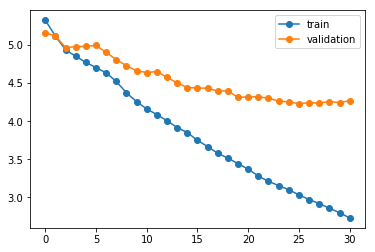

In [52]:
import matplotlib.pyplot as plt
print(len(train_losses),len(val_losses))

plt.figure()

times = np.linspace(0,len(train_losses)-1,len(train_losses))

plt.plot(times,train_losses,label = 'train',marker = 'o')
plt.plot(times,val_losses,label = 'validation',marker = 'o')

plt.legend()

plt.show()

In [54]:
print(val_losses.index(min(val_losses)),min(val_losses))

25 4.230975240468979


In [55]:
model_dir = './model/'
torch.save(model, model_dir+ 'NLP10.pt')

## validation 

In [80]:
model = torch.load(model_dir+ 'NLP10.pt')
test_loss = evaluate(model, test_iterator, criterion)
print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 4.415 | Test PPL:  82.695 |


In [95]:
source = next(iter(test_iterator)).src.detach().cpu().numpy()
target = next(iter(test_iterator)).trg.detach().cpu().numpy()

print(type(test_iterator),source,np.shape(source))

<class 'torchtext.data.iterator.BucketIterator'> [[   2    2    2 ...    2    2    2]
 [   4   10   10 ...    4    4  132]
 [ 505  497  701 ...  154  562 1954]
 ...
 [   3    3    1 ...    1    1    1]
 [   1    1    1 ...    1    1    1]
 [   1    1    1 ...    1    1    1]] (9, 128)


In [96]:
out = model(next(iter(test_iterator)).src,next(iter(test_iterator)).trg)

In [97]:
out = out.detach().cpu().numpy()

In [98]:
print(np.shape(out))

(10, 128, 2188)


In [99]:
source = next(iter(test_iterator)).src
target = next(iter(test_iterator)).trg
print(source.size(),target.size())

TRG.vocab

torch.Size([9, 128]) torch.Size([10, 128])


src: (sent_len, batch size)
trg: (sent_len, batch size)

In [119]:
type(SRC.vocab.freqs)


collections.Counter